## **Keras Grad-Cam**

**source:**
- Francois Chollet - Deep Learning with Python (2017, Manning Publications)

Le **GradCam** est une **technique de visualisation** : elle est utile pour comprendre quelles parties d'une image donnée ont conduit un convnet à sa décision finale de classification.

Elle est **utile pour déboguer** le processus de décision d'un convnet, **en particulier dans le cas d'une erreur de classification**. Elle vous permet également de **localiser des objets spécifiques** dans une image.

Cette catégorie générale de techniques est appelée visualisation de **class activation map (CAM)**, et consiste à produire des **heatmap** représentant les classes d'activationsur les images d'entrée. Une **class activation heatmap** est  associée à une **classe de sortie spécifique**, calculée pour chaque emplacement dans une image d'entrée, **indiquant l'importance de chaque emplacement par rapport à la classe considérée**.

Par exemple, si une image est utilisée dans un convnet chiens/chats, la **visualisation CAM** vous permet de **générer une carte thermique** pour la classe "chat", indiquant à quel point **les différentes parties de l'image ressemblent** à un chat, et également une carte thermique pour la classe "chien", indiquant à quel point les parties de l'image ressemblent à un chien.

L'implémentation spécifique que nous utiliserons est celle décrite dans "**Grad-CAM**" : **Visual Explanations** from Deep Networks via **Gradient-based** Localization" (Explications visuelles des réseaux profonds via la localisation par gradient).

Nous allons présenter cette technique en utilisant le réseau pré-entraîné **VGG16**.

In [ ]:
import tensorflow as tf
tf.__version__

'2.4.0'

## **Import des données et preprocessing**

Pour cela nous prenons l'image d'un dalmatien que nous transformons en variable d'entrée compréhensible pour **VGG16**: **image de taille 224 x 224**

Il faut aussi **prétraiter l'image** selon quelques règles qui sont incluses dans la fonction **preprocess_input** de la **librairie keras.applications.vgg16**.

*Il faut donc charger l'image, la redimensionner à 224 × 224, la convertir en un tenseur Numpy float32 et appliquer ces règles de prétraitement.*

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

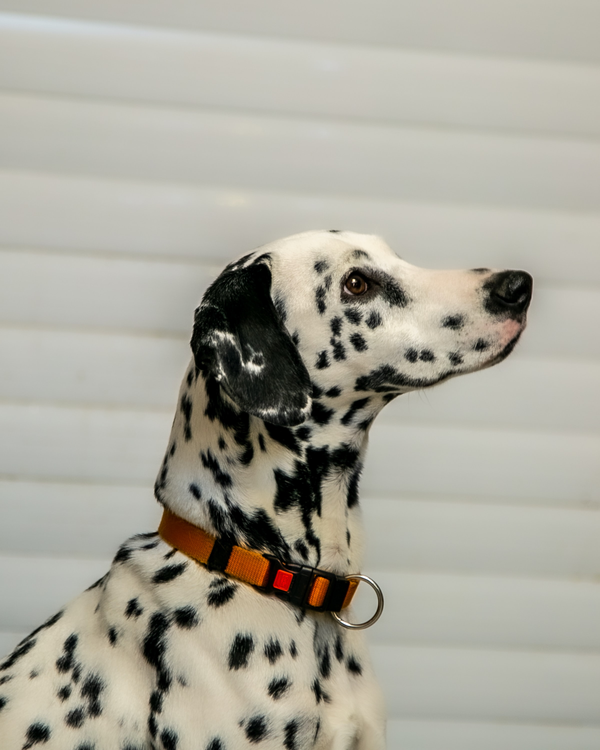

In [ ]:
from PIL import Image
im = (Image.open('/Dalmatian.jpg'))
im

In [ ]:
import tensorflow as tf
import numpy as np
from keras.applications.imagenet_utils import preprocess_input

def preprocess(img):
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    return img

image = preprocess((Image.open("/Dalmatian.jpg")).resize((224, 224), Image.ANTIALIAS))

## **Prédiction**

Nous pouvons maintenant **lancer le réseau pré-entraîné VGG16** sur l'image et **décoder son vecteur de prédiction** pour le ramener dans un format compréhensible pour nous

In [ ]:
#import tensorflow.keras.applications.imagenet_utils.decode_predictions as decode_predictions
from keras.applications.imagenet_utils import decode_predictions

predict = model.predict(image)
print('Predicted:', decode_predictions(predict,top=3))

Predicted: [[('n02110341', 'dalmatian', 0.9992306), ('n02109047', 'Great_Dane', 0.00025052085), ('n02100236', 'German_short-haired_pointer', 7.192213e-05)]]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


On peut voir que VGG16 est déjà entraîné à reconnaître les races de chiens.
**Le réseau a identifié** que l'image contenait un **dalmatien**.

Pour **comprendre** plus en profondeur **comment marche le réseau** on peut afficher les entrées du **vecteur de prédiction** (ces entrées s'activent lorsqu'elles repèrent une classe correspondant à la leur). 

Ici on voit que l'entrée qui a été **activée au maximum** est celle correspondant à la **classe "dalmatian"**, à l'indice 251.

In [ ]:
target_class = np.argmax(predict[0])
print("Target Class = %d"%target_class)

Target Class = 251


## **Feature-map et Gradient**

Pour **visualiser** les **parties de l'image** qui ressemblent le plus à un dalmatien, nous allons mettre en place Grad-CAM.

Pour cela nous prenons:
- **l'entrée "dalmatien"** dans le vecteur de prédiction
- la **feature-map** de sortie de la couche **block5_conv3**, la **dernière couche convolutionnelle** du **VGG16**

In [ ]:
dogRace_output = model.output[:, target_class]
last_conv_layer = model.get_layer('block5_conv3')

Nous prenons le **gradient** de la classe "dalmatien"(TensorShape([None, 14, 14, 512])) par rapport à la **feature-map** de sortie du **bloc5_conv3**.

Nous créons ensuite un **vecteur** de dimension (512,), où **chaque entrée** est l'**intensité moyenne du gradient** sur un canal spécifique de la feature-map.

*Suite à des problèmes de version de Keras, ré-executer depuis le début si il y a un problème à la ligne suivante*

In [ ]:
from keras import backend as K
tf.compat.v1.disable_eager_execution()

grads = K.gradients(dogRace_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))

Nous créons la variable *iterate* qui permet d'accéder aux **valeurs des quantités** que nous venons de définir : **pooled_grads** et la **feature-map** de sortie du **bloc5_conv3**, à partir d'un échantillion(image).

Nous récupérons donc la valeurs de **pooled_grads** et la **feature-map** de sortie du **bloc5_conv3**(en numpy.arrays) à partir de notre image de base.

In [ ]:
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([image])

## **Heatmap et Visualisation**

Nous **multiplions chaque canal**  dans la feature-map par **"l'importance de ce canal"** par rapport à la classe **"dalmatien"**.

Puis nous calculons **la moyenne par canal de la feature-map** ce qui nous donne la **heatmap** (carte thermique) de la classe d'activation.

In [ ]:
for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

À des fins de **visualisation**, nous allons également **normaliser** la carte thermique entre 0 et 1.

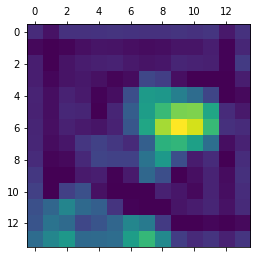

In [ ]:
import matplotlib.pyplot as plt

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

Finalement, nous utilisons **OpenCV** pour générer une image qui **superpose** la **heatmap** que nous avons obtenu à l'image originale.

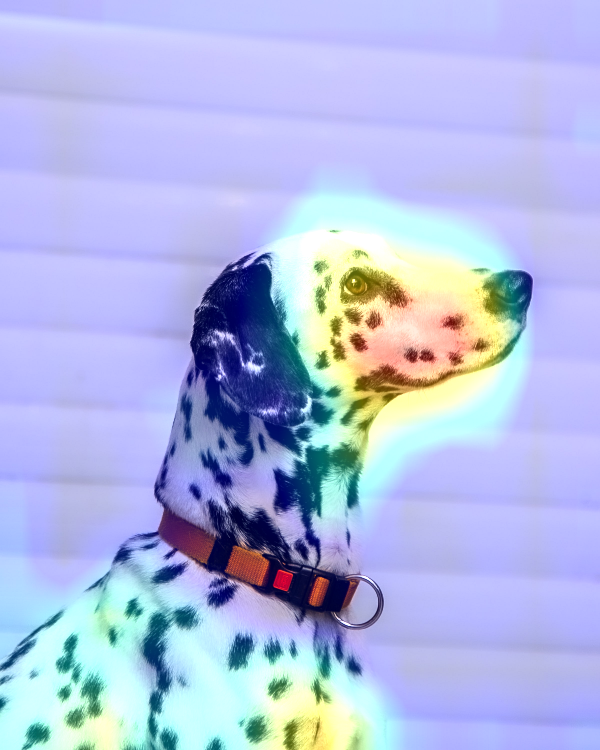

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('/Dalmatian.jpg')
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2_imshow(superimposed_img)

On peut ensuite sauvegarder, d'une part, la heatmap et d'une autre, l'image finale ! :) 

In [ ]:
cv2.imwrite('/Dalmatian_heatmap.jpg', heatmap)
cv2.imwrite('/Dalmatian_GradCam.jpg', superimposed_img)

True